In [1]:
import os
os.chdir(r'7 - Putting it together')
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)
from midi_encoding import *
from data_loading import *
from model import *

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
!nvidia-smi

Tue Oct  1 18:30:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0  On |                  Off |
| 30%   32C    P0             45W /  450W |    2419MiB /  24564MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
dataset_name = 'lakh_piano-vg_large'
midi_path = Path(f'../data/midi/{dataset_name}')
score_path = Path(f'../data/numpy/{dataset_name}')
midi_file_paths = list(midi_path.rglob('*.mid')) #[f for f in os.listdir(midi_path) if os.path.isfile(os.path.join(midi_path, f))]

# Ensure files are shuffled directly after assignment.
# If they are shuffled in a different cell, and that cell is run multiple times, the order will change as we are shuffling the already-shuffled list.
random.seed(42)
random.shuffle(midi_file_paths)

len(midi_file_paths)

20816

In [4]:
n1 = int(0.8 * len(midi_file_paths))
n2 = int(0.9 * len(midi_file_paths))
train_filepaths = midi_file_paths[:n1]
valid_filepaths = midi_file_paths[n1:n2]
test_filepaths = midi_file_paths[n2:]

print(f'Train file names: {len(train_filepaths)}, Valid file names: {len(valid_filepaths)}, Test file names: {len(test_filepaths)}')

Train file names: 16652, Valid file names: 2082, Test file names: 2082


In [5]:
max_vocab_size = 389
vocab_name = f'{dataset_name}-actions_{max_vocab_size}'
vocab_state_dict_path = Path(f'../data/vocab/{vocab_name}.pkl')

MidiDataset says "Look for the given filenames at the given score path. Load if they exist, if not create them'.

We can use this to encode with the trained vocab if we pass it in as a param.

In [6]:
sample_length = 256
max_file_length = 32

if not vocab_state_dict_path.exists():
    
    # Load (and / or create) dataset of unmerged samples
    untrained_vocab = MusicVocab()
    untrained_vocab_size = untrained_vocab.initial_size
    untrained_vocab.train(None, untrained_vocab_size) # Required to init actions, not adding any tokens
    print(f'Untrained vocab size: {untrained_vocab_size}')
    vocab_training_dataset = MidiDataset(untrained_vocab, midi_file_paths, score_path, sample_length, max_file_length)
    print(f"Loading unmerged samples...")
    vocab_training_dataset.load_samples("cpu")

    # Train the vocab on the unmerged dataset, so it can learn the merges
    print(f"Training vocab, adding {max_vocab_size - untrained_vocab_size} tokens...")
    trained_vocab = MusicVocab()
    trained_vocab.train(vocab_training_dataset, max_vocab_size=max_vocab_size)
    print(f'Trained vocab size: {trained_vocab.size}')
    print(f"Saving vocab with actions:\n{trained_vocab.actions}")
    trained_vocab.save(vocab_state_dict_path)
else:
    print(f"Loading vocab...")
    trained_vocab = MusicVocab()
    trained_vocab.load(vocab_state_dict_path)
    print(f"Loaded vocab with actions:\n{trained_vocab.actions}")
    print(f'Trained vocab size: {trained_vocab.size}')

Loading vocab...
Loaded vocab with actions:
[]
Trained vocab size: 389


In [7]:
merged_score_path = Path(f'../data/numpy/{vocab_name}')
os.makedirs(merged_score_path, exist_ok=True)

# Use the trained vocab to load GPU datasets, which will create merged samples if we pass a new path
train_dataset = MidiDataset(trained_vocab, train_filepaths, merged_score_path, sample_length, max_file_length)
valid_dataset = MidiDataset(trained_vocab, valid_filepaths, merged_score_path, sample_length, max_file_length)
test_dataset = MidiDataset(trained_vocab, test_filepaths, merged_score_path, sample_length, max_file_length)

print(f'Loading train samples')
train_dataset.load_samples(device)

print(f'Loading valid samples')
valid_dataset.load_samples(device)

print(f'Loading test samples')
test_dataset.load_samples(device)

Loading train samples
Encoding


/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting gene

Encoded
Loading valid samples
Encoding


/opt/conda/lib/python3.10/site-packages/torch/nested/__init__.py:166: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK

Encoded
Loading test samples
Encoding


/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting gene

Encoded


In [8]:
print(f'Train files: {len(train_dataset.file_lengths)}, Valid files: {len(valid_dataset.file_lengths)}, Test files: {len(test_dataset.file_lengths)}')

Train files: 7714, Valid files: 969, Test files: 957


In [9]:
# Batch size can be changed for a second phase of training quite quickly, it only requires re-computing the indices, not re-loading the data.
batch_size = 32
train_sampler = ContiguousBatchSampler(train_dataset)
valid_sampler = ContiguousBatchSampler(valid_dataset)
test_sampler = ContiguousBatchSampler(test_dataset)

print(f'Precomputing indices')
train_sampler.precompute_indices(batch_size)
valid_sampler.precompute_indices(batch_size)
test_sampler.precompute_indices(batch_size)

train_data_loader = DataLoader(train_dataset, batch_sampler=train_sampler)
valid_data_loader = DataLoader(valid_dataset, batch_sampler=valid_sampler)
test_data_loader = DataLoader(test_dataset, batch_sampler=test_sampler)

Precomputing indices


In [10]:
model_name = f'midi_transformer_knn-xl_{vocab_name}-large-3'
model_load_path = Path(f'../data/checkpoints/{model_name}.dat')
model_save_path = Path(f'../data/checkpoints/{model_name}.dat')
log_dir = Path(f'../tensorboard/{model_name}')
tensorboard_writer = SummaryWriter(log_dir)

In [11]:
model = DecoderTransformer_KNN_XL(vocab=trained_vocab, sample_length=sample_length, max_file_length=max_file_length, device=device, use_knn=True, n_embed=512, n_head=8, n_layer=8)

print(sum(p.numel() for p in model.parameters()))

26147725


In [12]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
token_embedding.weight 	 torch.Size([389, 512])
rel_pos.relative_attention_embedding.weight 	 torch.Size([32, 8])
rel_pos_knn.relative_attention_embedding.weight 	 torch.Size([32, 8])
beat_embedding.weight 	 torch.Size([32, 512])
bar_embedding.weight 	 torch.Size([1024, 512])
blocks.0.attention.key.weight 	 torch.Size([512, 512])
blocks.0.attention.query.weight 	 torch.Size([512, 512])
blocks.0.attention.value.weight 	 torch.Size([512, 512])
blocks.0.attention.project.weight 	 torch.Size([512, 512])
blocks.0.attention.project.bias 	 torch.Size([512])
blocks.0.ff.net.0.weight 	 torch.Size([2048, 512])
blocks.0.ff.net.0.bias 	 torch.Size([2048])
blocks.0.ff.net.3.weight 	 torch.Size([512, 2048])
blocks.0.ff.net.3.bias 	 torch.Size([512])
blocks.0.layer_norm1.weight 	 torch.Size([512])
blocks.0.layer_norm1.bias 	 torch.Size([512])
blocks.0.layer_norm2.weight 	 torch.Size([512])
blocks.0.layer_norm2.bias 	 torch.Size([512])
blocks.1.attention.key.weight 	 torch.Size([51

In [13]:
learning_rate = 3e-4
weight_decay = 1e-3
eval_iters = 100

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

@torch.no_grad()
def estimate_loss(data_loader):
    model.eval()
        
    xl_memories = None
    losses = torch.zeros(eval_iters)
    
    # Not working
    # Start at a random point in the data, making sure we have enough data to evaluate
    # offset = random.randint(0, len(data_loader.dataset) - (eval_iters + 1))
    # data_iter = itertools.islice(iter(data_loader), offset, None)

    data_iter = iter(data_loader)

    for k in range(eval_iters):
        file_idxs, batch = next(data_iter)
        X, Y = batch[:, :-1], batch[:, 1:, 0] # drop absolute position from Y
        _, loss, xl_memories = model(file_idxs, X, xl_memories, Y)
        losses[k] = loss.item()

    model.train()
    
    return losses.mean()

In [14]:
average_log_losses = {  
    "train" : [],
    "val" : []
}

epochs = 0

def save_checkpoint(iterations):
    train_loss = estimate_loss(train_data_loader)
    val_loss = estimate_loss(valid_data_loader)
    tensorboard_writer.add_scalar('Loss/train', train_loss, iterations)
    tensorboard_writer.add_scalar('Loss/val', val_loss, iterations)
    train_log_loss = train_loss.log10().item()
    val_log_loss = val_loss.log10().item()
    average_log_losses['train'].append(train_log_loss)
    average_log_losses['val'].append(val_log_loss)
    print(f'Epoch {epochs} / Iteration {iterations}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save({
        'iter': iterations,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'vocab_state_dict': trained_vocab.state_dict(),
        'losses': average_log_losses,
        'epochs': epochs
    }, model_save_path)

In [15]:
eval_interval = 200
total_iterations = 600000
start_iter = 0

if model_load_path.exists():
    checkpoint = torch.load(model_load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    average_log_losses = checkpoint['losses']
    iterations = checkpoint['iter']
    epochs = checkpoint['epochs']
    start_iter = iterations + 1
    print(f"Loaded model from iteration {iterations}")

Loaded model from iteration 300000


In [16]:
model.train()

remaining_iters = total_iterations - start_iter
if remaining_iters != -1:

    print(f"Training from epoch {epochs} for {remaining_iters} iterations")
    
    xl_memories = None
    initial_file_idxs = None
    train_data = iter(train_data_loader)
    offset_iter = start_iter

    for iteration in range(remaining_iters):
        offset_iter = iteration + start_iter

        if offset_iter % eval_interval == 0:
            # Because we don't explicitly clear xl and knn mem here, there is always a risk that the eval loop leaves the file idx
            # the same as the train loop, but with memories of the 'future' which aren't cleared. It could also break the epoch counter.
            # The risk would be much smaller with a bigger data set, but with vg_large we loop through the data quite quickly.
            save_checkpoint(offset_iter)

        # Configure minibatch
        file_idxs, batch = next(train_data)

        if initial_file_idxs is None:
            initial_file_idxs = file_idxs

        if torch.equal(initial_file_idxs, file_idxs):
            epochs += 1
        
        X, Y = batch[:, :-1], batch[:, 1:, 0]

        # Forward pass
        logits, loss, xl_memories = model(file_idxs, X, xl_memories, Y)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    save_checkpoint(offset_iter + 1)

Training from epoch 266 for 299999 iterations


/opt/conda/lib/python3.10/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


Epoch 270 / Iteration 300200: Train Loss: 1.0895, Val Loss: 1.1520
Epoch 270 / Iteration 300400: Train Loss: 1.0913, Val Loss: 1.1431
Epoch 270 / Iteration 300600: Train Loss: 1.0986, Val Loss: 1.1442
Epoch 270 / Iteration 300800: Train Loss: 1.1016, Val Loss: 1.1476
Epoch 270 / Iteration 301000: Train Loss: 1.1030, Val Loss: 1.1482
Epoch 270 / Iteration 301200: Train Loss: 1.1041, Val Loss: 1.1462
Epoch 270 / Iteration 301400: Train Loss: 1.1029, Val Loss: 1.1459
Epoch 270 / Iteration 301600: Train Loss: 1.1167, Val Loss: 1.1585
Epoch 270 / Iteration 301800: Train Loss: 1.1090, Val Loss: 1.1492
Epoch 270 / Iteration 302000: Train Loss: 1.1067, Val Loss: 1.1489
Epoch 270 / Iteration 302200: Train Loss: 1.1018, Val Loss: 1.1435


KeyboardInterrupt: 

In [17]:
print('Final training loss:', 10 ** average_log_losses['train'][-1])

Final training loss: 1.108006235808117


In [18]:
print('Final validation loss:', 10 ** average_log_losses['val'][-1])

Final validation loss: 1.148891330088213


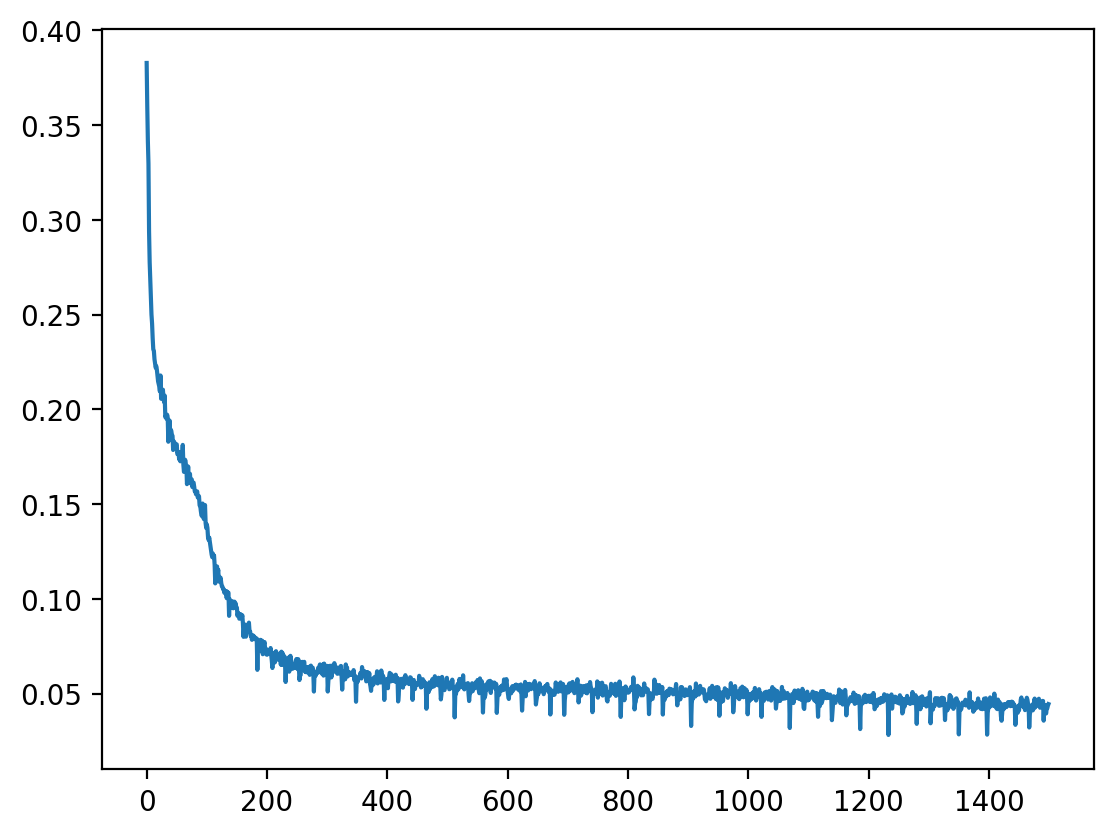

In [19]:
plt.plot(average_log_losses['train'][1:])

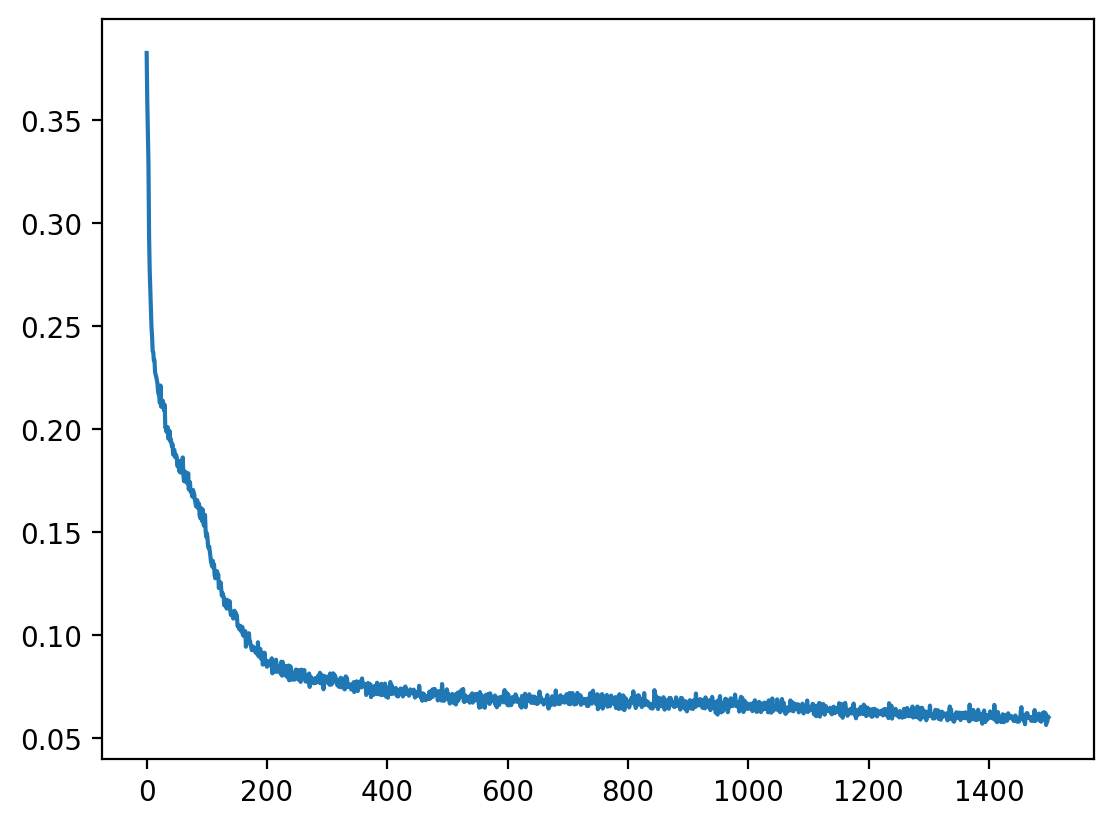

In [20]:
plt.plot(average_log_losses['val'][1:])

In [21]:
init_idx = torch.zeros((1,1,2), dtype=torch.long, device=device)
generated_tokens = model.generate(init_idx, max_new_tokens=512).cpu()

In [22]:
generated_tokens.shape

torch.Size([1, 513, 2])

In [23]:
trained_vocab.itos[0]

'<|sos|>'

In [24]:
score = generated_tokens[0, :, 0]
trained_vocab.to_tokens(score.tolist())

'<|sos|> <|sep|> d32 n67 d4 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d8 <|sep|> d8 n67 d4 <|sep|> d4 n67 d4 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d4 <|sep|> d4 n67 d2 <|sep|> d4 n67 d4 <|sep|> d4 n67 d2 <|sep|> d4 n67 d4 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d4 <|sep|> d4 n67 d4 <|sep|> d4 n67 d4 <|sep|> d4 n67 d2 <|sep|> d2 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n70 d2 <|sep|> d8 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d2 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d4 <|sep|> d4 n67 d2 <|sep|> d4 n67 d4 n67 d4 n52 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 n59 d2 <|sep|> d4 n55 d4 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n67 d2 <|sep|> d4 n72 d2 <|sep|> d4 n70 d2 <|sep|> d4 n67 

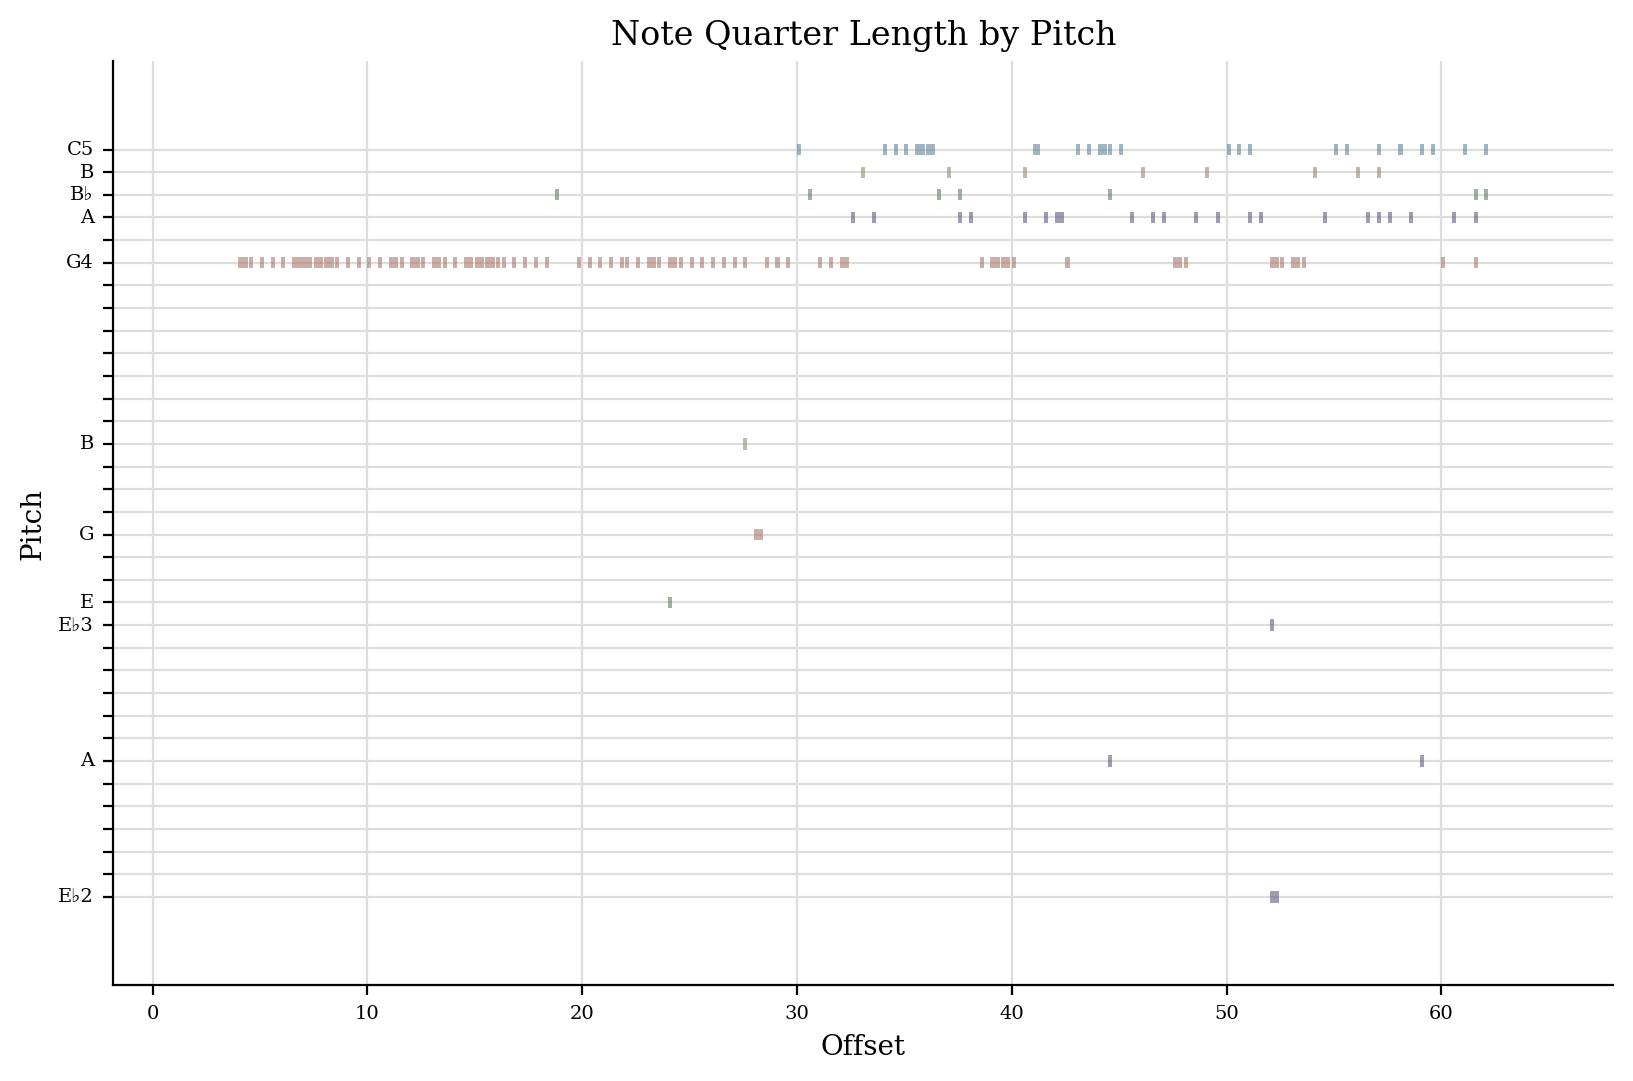

In [25]:
generated_stream = idx_to_stream_enc(np.array(score), trained_vocab)
generated_stream.plot()

In [26]:
generated_stream.show('midi')

../data/midi/lakh_piano-vg_large/lakh_clean_piano/The Beatles/Help!.mid


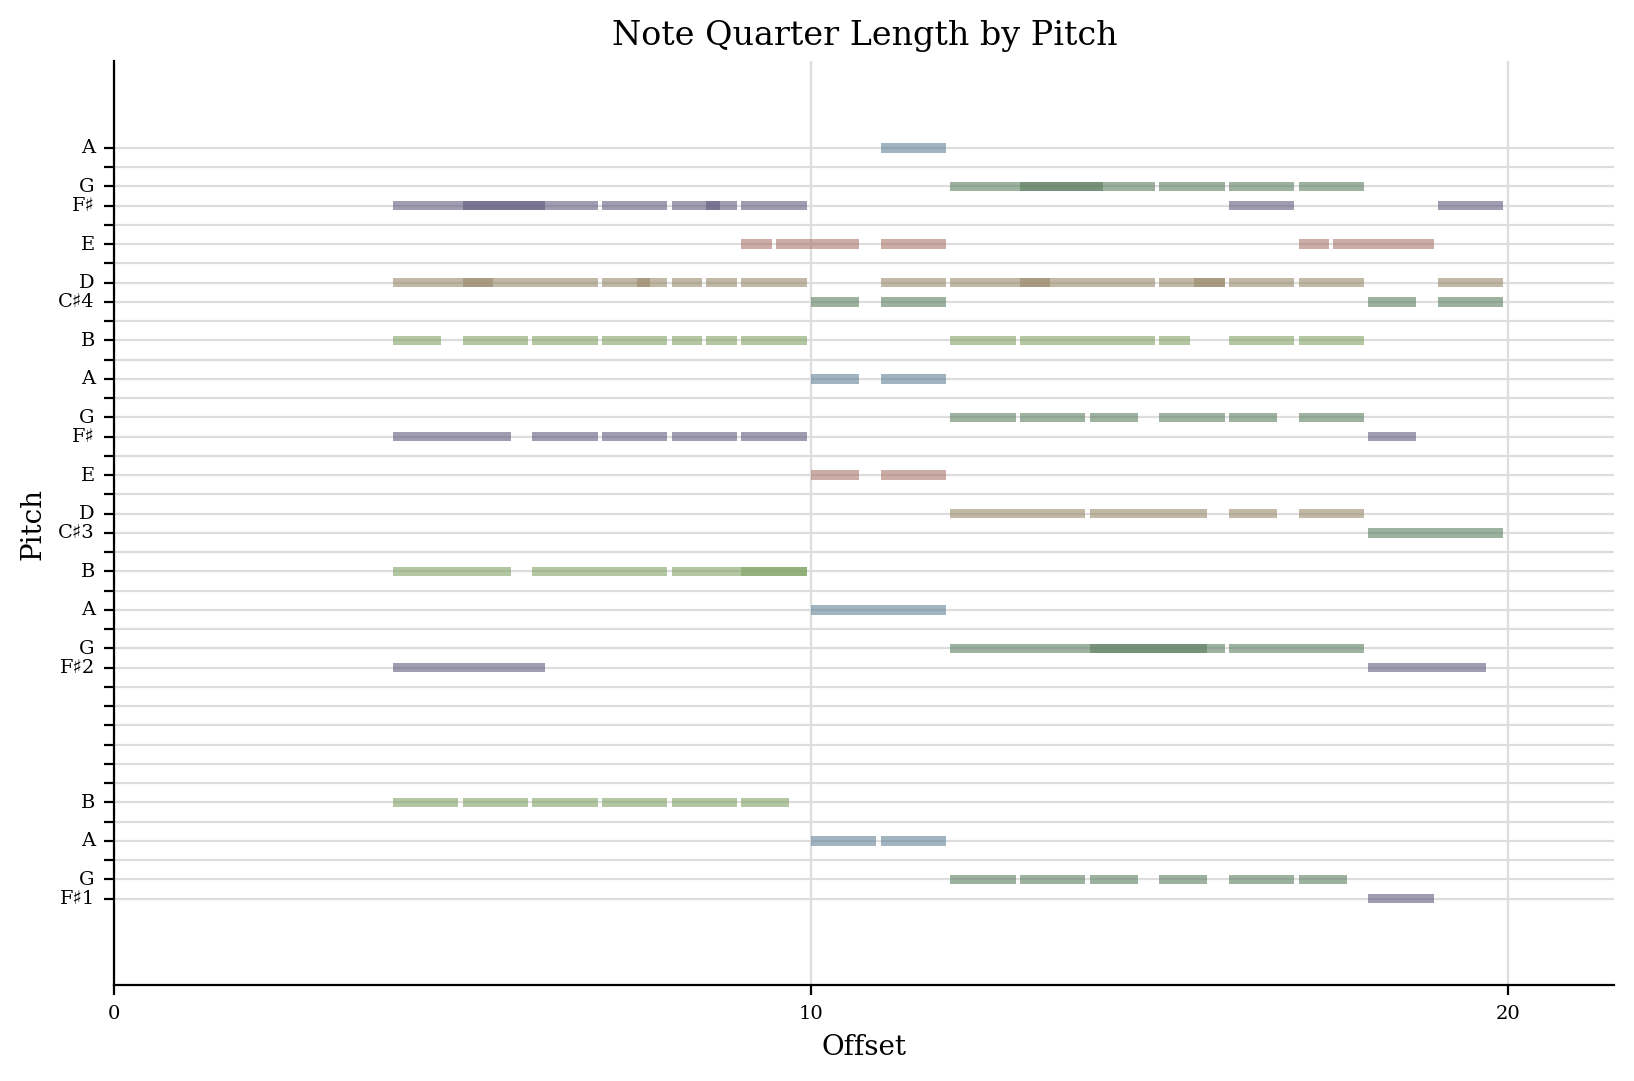

In [100]:
random_test_path = random.choice(test_filepaths)
print(random_test_path)
random_test_idx_score = midifile_to_idx_score(random_test_path, trained_vocab)
random_test_intro = random_test_idx_score[:sample_length]
random_test_intro_stream = idx_to_stream_enc(np.array(random_test_intro[:, 0]), trained_vocab)
random_test_intro_stream.plot()

In [101]:
random_test_intro_stream.show('midi')

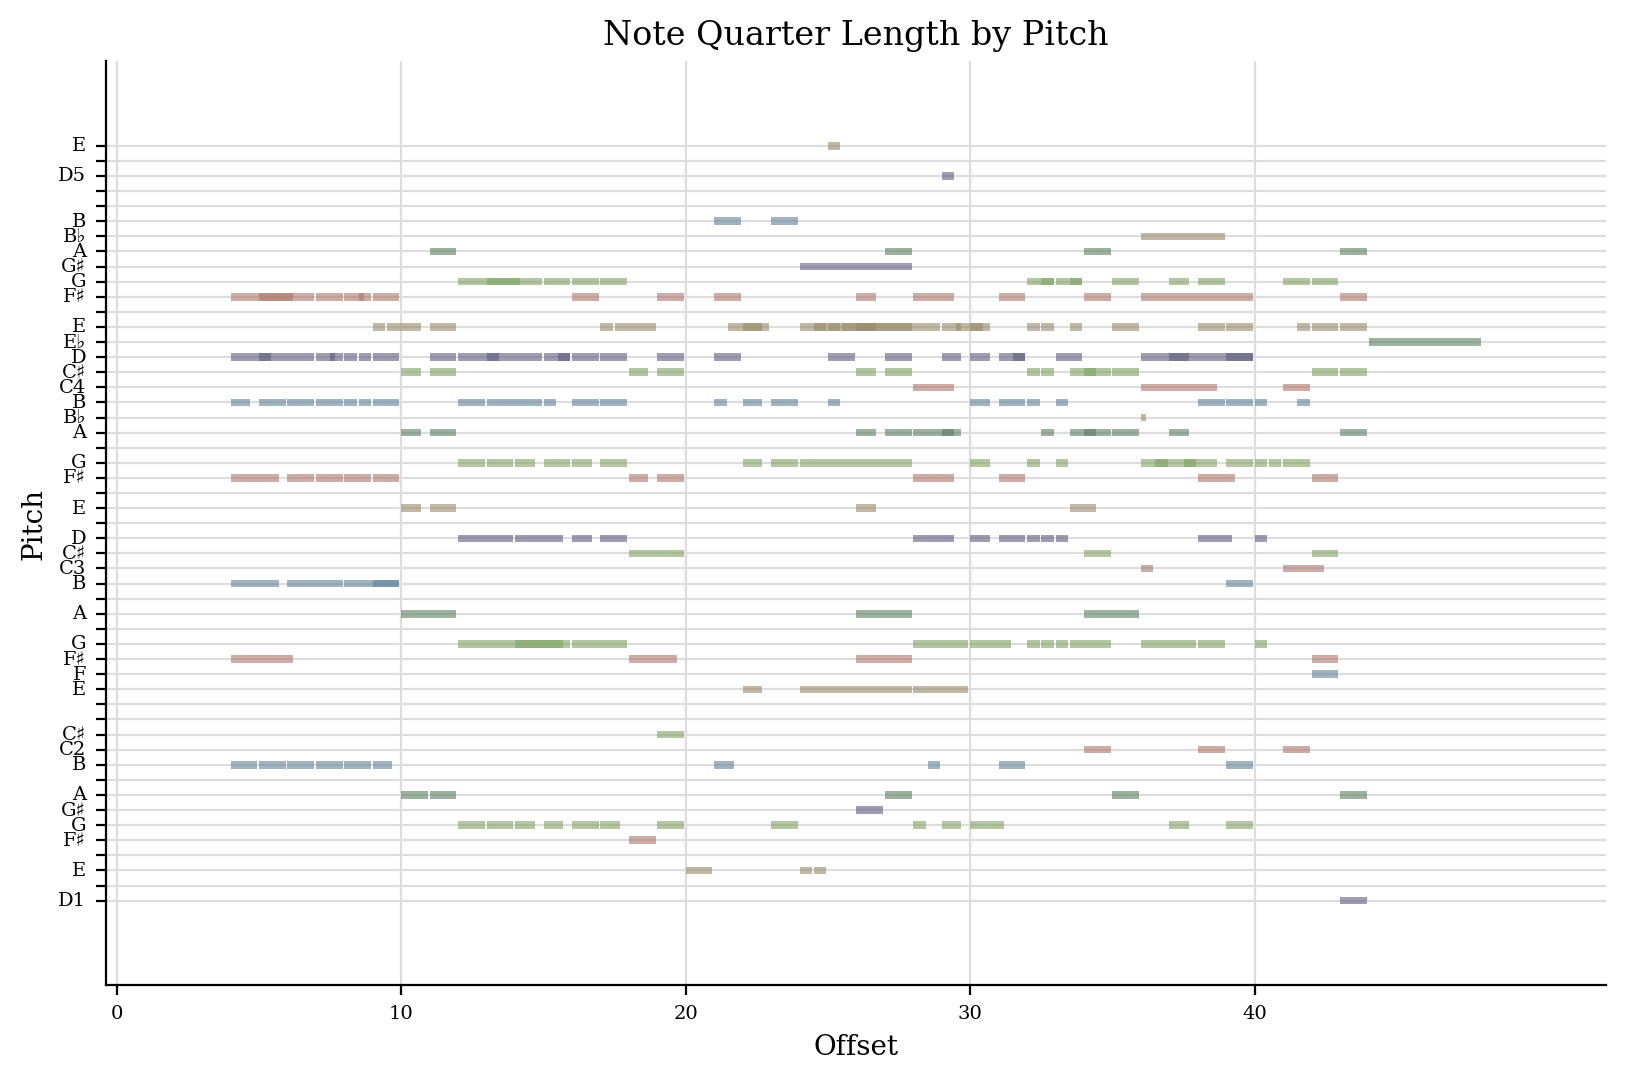

In [102]:
random_test_init = torch.tensor(random_test_intro, device=device).unsqueeze(0)
random_test_continued = model.generate(random_test_init, max_new_tokens=512).cpu()[0, :, 0]
random_test_continued_stream = idx_to_stream_enc(np.array(random_test_continued), trained_vocab)
random_test_continued_stream.plot()

In [103]:
random_test_continued_stream.show('midi')

In [104]:
def group_by_timestep(data, include_position=False):
    grouped = {}
    for idx, position in data:
        if position not in grouped:
            grouped[position] = []
        grouped[position].append(idx)
    
    if include_position:
        result = [(tuple(values), position) for position, values in grouped.items()]
    else:
        result = [tuple(values) for values in grouped.values()]
    return result

data = [[1, 0], [2, 0], [3, 0], [4, 1], [5, 1], [6, 2], [7, 2], [8, 2], [9, 2]]

grouped_data = group_by_timestep(data, include_position=False)
print(grouped_data)

[(1, 2, 3), (4, 5), (6, 7, 8, 9)]


In [105]:
grouped_data = group_by_timestep(data, include_position=True)
print(grouped_data)

[((1, 2, 3), 0), ((4, 5), 1), ((6, 7, 8, 9), 2)]


In [106]:
actions = {}
grouped_idxs = [(1, 2, 3), (4, 5), (6, 7, 8, 9), (1, 2, 3), (1, 2, 3), (6, 7, 8, 9), (4, 5), (4, 5), (4, 5)]
for action in grouped_idxs:
    actions[action] = actions.get(action, 0) + 1
actions

{(1, 2, 3): 3, (4, 5): 4, (6, 7, 8, 9): 2}

In [107]:
sorted_actions = {k: v for k, v in sorted(actions.items(), key=lambda item: item[1], reverse=True)}
sorted_actions

{(4, 5): 4, (1, 2, 3): 3, (6, 7, 8, 9): 2}

In [108]:
top_actions = list(sorted_actions.keys())[:2]
top_actions

[(4, 5), (1, 2, 3)]

In [109]:
initial_size = 10

def try_replace(action, position):
    if action in top_actions:
        return [[initial_size + top_actions.index(action)], position]
    else:
        return [list(action), position]
        
replaced_score = [try_replace(action, position) for action, position in grouped_data]
replaced_score

[[[11], 0], [[10], 1], [[6, 7, 8, 9], 2]]

In [110]:
note_idx_score = []
pos_score = []
for (action, position) in replaced_score:
    for index in action:
        note_idx_score.append(index)
        pos_score.append(position)
note_idx_score

[11, 10, 6, 7, 8, 9]

In [111]:
pos_score

[0, 1, 2, 2, 2, 2]

In [112]:
for idx, action in enumerate(top_actions):
   print(' '.join([str(a) for a in action]))

4 5
1 2 3
